In [ ]:
def printfig(fig, name):
    dpi_exp = None
    bbox = 'tight'
    path = '../../paper/5f22d412742c360001c92b46/fig/'
    #path = '../../GrimaldiEtAl2020HOTS_clone_laurent/fig'
    fig.savefig(path+name, dpi = dpi_exp, bbox_inches=bbox, transparent=True)

# Illustration of homeostatic gain control

In [ ]:
%cd '../HOTS'
from Tools import netparam
import numpy as np
import matplotlib.pyplot as plt

sigma = None
homeinv = False
jitter = False
R = 2
tau = 5
nbclust = [4,8,16]
filt = 2
timestr = '2021-03-29'
dataset = 'nmnist'
name = 'hots'

hotshom, homeotest = netparam(name, filt, tau, nbclust, sigma, homeinv, jitter, timestr, dataset, R)

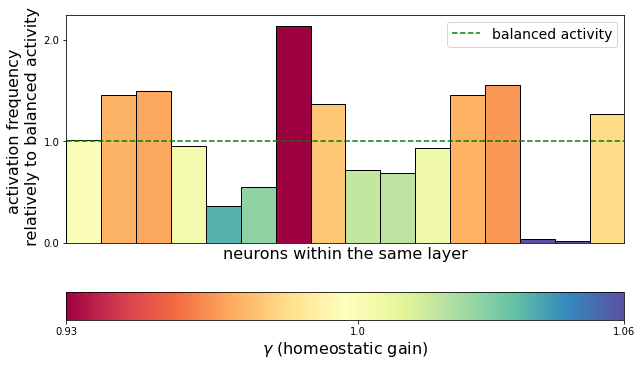

In [2]:
def gainhom(x):
    homparam = [.25, 1]
    N = 4
    return np.exp(homparam[0]*(1/N-N**homparam[1]*x))

gain = gainhom(hotshom.L[2].cumhisto/np.sum(hotshom.L[2].cumhisto))
colors = (gain-min(gain))/(max(gain)-min(gain))
colormap = plt.cm.get_cmap('Spectral', 1000);
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(np.arange(16), hotshom.L[2].cumhisto/np.sum(hotshom.L[2].cumhisto), width=1, align='edge', ec="k", color=colormap(colors));
ax.set_xlim([0,16]);
ax.set_xlabel('neurons within the same layer', fontsize=16);
ax.set_ylabel('activation frequency \n relatively to balanced activity', fontsize=16);
ax.set_yticks([0,1/16, 2/16, 3/16])
ax.set_yticklabels(ax.get_yticks()*16)
ax.set_xticks(());
ax.hlines(1/16,0,16, linestyles='dashed', color='green', label='balanced activity');
ax.legend(fontsize = 14);
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=colormap), orientation='horizontal', ticks=[min(gain), 1, max(gain)])
cbar.set_label('$\gamma$ (homeostatic gain)', labelpad=3, fontsize=16);
mini = min(gain)
maxi = max(gain)
interval = (max(gain)-min(gain))/5
onepoint = (1-mini)/(maxi-mini)
cbar.set_ticks([0,onepoint,1]);
cbar.ax.set_xticklabels(np.round([mini, 1, maxi],2));

In [ ]:
printfig(fig, 'homeostasis.pdf')

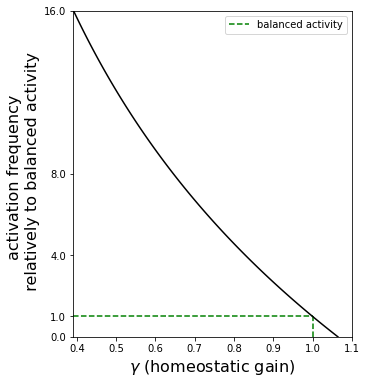

In [9]:
x = np.linspace(0,1,100)
y = gainhom(x)
fig, ax = plt.subplots(figsize=(5,6))
ax.plot(y,x, 'k')
ax.set_ylabel('activation frequency \n relatively to balanced activity', fontsize=16);
ax.set_xlabel('$\gamma$ (homeostatic gain)', fontsize=16);
ax.set_yticks([0,1/16, 4/16, 8/16, 1])
ax.set_yticklabels(ax.get_yticks()*16)
ax.vlines(1,0,1/16, linestyles='dashed', color='green', label='balanced activity')
ax.hlines(1/16,0.39,1, linestyles='dashed', color='green')
ax.axis([0.39,1.1,0,1]);
ax.legend();

In [ ]:
printfig(fig, 'homeogaincurve.pdf')

# Stream of events illustration

Using downloaded and verified file: ../Data/pips_test.tar.gz
Extracting ../Data/pips_test.tar.gz to ../Data/


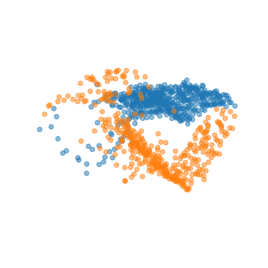

In [7]:
import tonic
learningset = tonic.datasets.POKERDVS(save_to='../Data/', train = False,
                                transform=None)
loader = tonic.datasets.DataLoader(learningset, shuffle=True)

X_on, Y_on, T_on, X_off, Y_off, T_off = ([] for i in range(6))
iev = 100
events, target = next(iter(loader))
target_event = events.shape[1]
target_event = 1000
while iev<target_event:
    x,y,t,p = events[0][iev][learningset.ordering.find("x")].item(), \
            events[0][iev][learningset.ordering.find("y")].item(), \
            events[0][iev][learningset.ordering.find("t")].item(), \
            events[0][iev][learningset.ordering.find("p")].item()
    if p:
        X_on.append(x)
        Y_on.append(abs(learningset.sensor_size[1]-y))
        T_on.append(t)
    else:
        X_off.append(x)
        Y_off.append(abs(learningset.sensor_size[1]-y))
        T_off.append(t)
    iev+=1
fig = plt.figure(figsize=(10,5))
sub1 = fig.add_subplot(1,2,1, projection="3d")
sub1.scatter(T_on, X_on, Y_on, cmap= plt.cm.plasma, alpha=0.5)
sub1.scatter(T_off, X_off, Y_off, cmap= plt.cm.plasma, alpha=0.5)
#sub1.arrow([0,max(T_off)], [0,0], [0,0])
sub1.view_init(10,-40)
sub1.grid(b = None)
sub1.set_xlabel('time')
sub1.axis('off')
plt.show()

In [ ]:
printfig(fig, 'stream.png')

# Time Surface illustration

In [9]:
from TimeSurface import TimeSurface

In [10]:
learningset = tonic.datasets.NMNIST(save_to='../Data/', train = False,
                                transform=None)
loader = tonic.datasets.DataLoader(learningset, batch_size=1, shuffle=True)

TS = TimeSurface(R=2,tau=5*10e3,camsize=[34,34])
events, target = next(iter(loader))
# target_event = 3300
flxT = TS.spatpmat.copy()
flxT[:] = np.nan
iev = 0
while iev<events.shape[1]:
    x,y,t,p = events[0][iev][learningset.ordering.find("x")].item(), \
                events[0][iev][learningset.ordering.find("y")].item(), \
                events[0][iev][learningset.ordering.find("t")].item(), \
                events[0][iev][learningset.ordering.find("p")].item(),
    flxT[p,x,y] = t
    ts, activ = TS.addevent(x,y,t,p)
    iev+=1

Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/


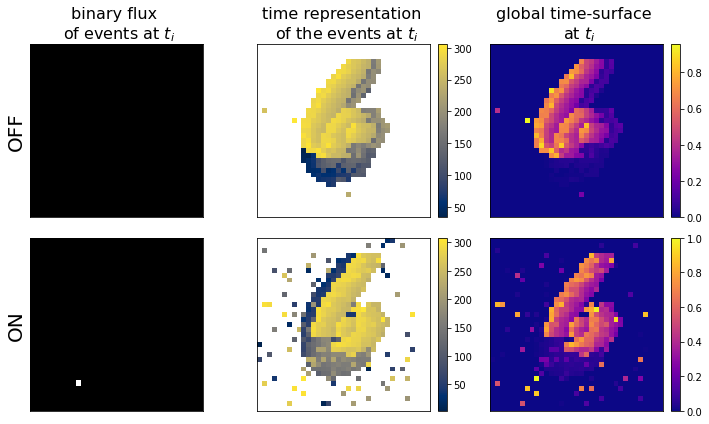

In [11]:
polaritiz = ['OFF','ON']
gamma = 1
fig, axs = plt.subplots(2,3,figsize=(10,6))

Ti = np.zeros(learningset.sensor_size)
singev = axs[abs(p-1),0].imshow(Ti.T, cmap='gray')
axs[abs(p-1),0].set_title('binary flux \n of events at $t_i$', fontsize=16)
axs[abs(p-1),0].set_ylabel(f'{polaritiz[abs(p-1)]}', fontsize=20)
axs[abs(p-1),0].set_xticks(())
axs[abs(p-1),0].set_yticks(())

Ti[x,y] = 1
singev = axs[p,0].imshow(Ti.T, cmap='gray')
#axs[p,0].set_title('binary flux of events at $t_i$', fontsize=16) #for NN
if p==0:
    axs[p,0].set_title('event recording at $t_i$', fontsize=16)
axs[p,0].set_ylabel(f'{polaritiz[p]}', fontsize=20)
axs[p,0].set_xticks(())
axs[p,0].set_yticks(())

for p in [0,1]:
    T = axs[p,1].imshow(flxT[p].T*1e-3, cmap='cividis')
    #axs[p,1].set_title('T flux at $t_i$ (in $ms$)', fontsize=16) #for NN
    if p==0:
        axs[p,1].set_title('time representation \n of the events at $t_i$', fontsize=16)
    axs[p,1].set_xticks(())
    axs[p,1].set_yticks(())
    plt.colorbar(T, ax=axs[p,1], fraction=0.046, pad=0.04);
    
    S = axs[p,2].imshow(TS.spatpmat[p].T, cmap=plt.cm.plasma)
    #axs[p,2].set_title('S flux at $t_i$', fontsize=16) #for NN
    if p==0:
        axs[p,2].set_title('global time-surface \n at $t_i$', fontsize=16)
    axs[p,2].set_xticks(())
    axs[p,2].set_yticks(())
    cbar = plt.colorbar(S, ax=axs[p,2], fraction=0.046, pad=0.04);
    #cbar.set_label(fonsize=16)
    
fig.tight_layout()

In [ ]:
printfig(fig, 'flux.pdf')

# Channels

In [217]:
import numpy as np
import matplotlib.pyplot as plt
nb_events = 50
nb_channels = 10
tmax = 1000
tau = 100
a = np.random.randint(nb_channels,size = nb_events)
t = np.random.randint(tmax,size = nb_events)
t = np.sort(t)
t = np.unique(t)
a = a[:len(t)]

#time = np.linspace(0,max(t)*3,max(t)*3)
#time = np.linspace(0,max(t)+1,max(t)+1)

y = np.zeros([nb_channels, max(t)+1])#len(time)])
for c in range(nb_channels):
    t_ev_c = t[np.where(a==c)[0]]
    for i in range(len(t_ev_c)):
        x_tp = np.linspace(0,max(t)-t_ev_c[i],max(t)-t_ev_c[i])
        y_tp = np.exp(-x_tp/tau)
        y[c,t_ev_c[i]:t_ev_c[i]+len(y_tp)] = y_tp

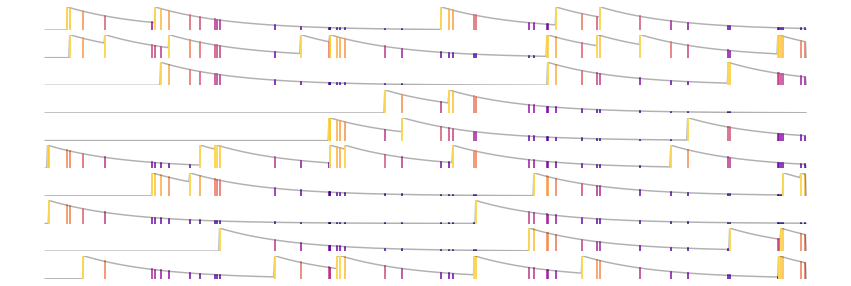

In [218]:
fig, ax = plt.subplots(10,1,figsize = (15,5))
color = plt.cm.plasma(np.linspace(0,0.9,max(t)+1))
for c in range(nb_channels):
    ax[c].plot(y[c,:],'k', alpha=0.3)
    ax[c].axis('off')
    ax[c].set_ylim([0,1])
    t_ev_c = t[np.where(a==c)[0]]
    for i in range(len(t_ev_c)):
        ax[c].plot([t_ev_c[i],t_ev_c[i]],[0,1], color = 'white')
        #ax[c].plot([t_ev_c[i],t_ev_c[i]],[0,1], color = 'yellow')
        for cha in range(nb_channels):
            ax[cha].plot([t_ev_c[i],t_ev_c[i]],[0,y[cha,t_ev_c[i]]], color = (color[int(len(color)*y[cha,t_ev_c[i]]-1),:]))
            if t_ev_c[i] == t[-1]:
                ax[cha].plot([t[-1]-1,t[-1]-1],[0,y[cha,-2]], color = 'white')
                ax[cha].plot([t[-1]-1,t[-1]-1],[0,y[cha,-2]], color = (color[int(len(color)*y[cha,-2]-1),:]))
    # last in red
    #tlast = t[-1]-1
    #ax[c].plot([tlast,tlast],[0,y[c,tlast]], color = (color[t_ev_c[i],:]), alpha=1)
#ax[a[-1]].plot([tlast,tlast],[0,1], color = 'red', alpha=1);

In [159]:
printfig(fig, 'inputlayer2.pdf')

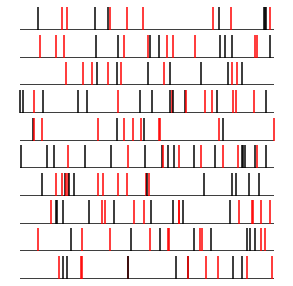

In [54]:
nb_events = 200
nb_channels = 10
tmax = 1000
tau = 100
a = np.random.randint(nb_channels, size = nb_events)
t = np.random.randint(tmax, size = nb_events)
t = np.sort(t)
t = np.unique(t)
a = a[:len(t)]

time = np.linspace(0,max(t),max(t))

fig, ax = plt.subplots(10,1,figsize = (5,5))
color = ['black', 'red']
for c in range(nb_channels):
    ax[c].axis('off')
    ax[c].set_ylim([0,1])
    t_ev_c = t[np.where(a==c)[0]]
    for i in range(len(t_ev_c)):
        ax[c].plot([t_ev_c[i],t_ev_c[i]],[0,1], color = color[np.random.randint(2)])
    ax[c].hlines(0, 0, max(t), color = 'black')

In [55]:
printfig(fig, 'inputnetwork.pdf')

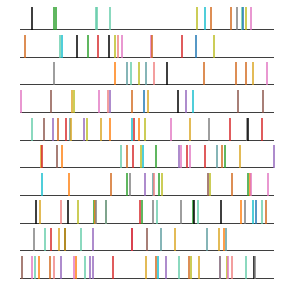

In [56]:
nb_events = 200
nb_channels = 10
nb_pola = 16
tmax = 1000
tau = 100
a = np.random.randint(nb_channels, size = nb_events)
t = np.random.randint(tmax, size = nb_events)
t = np.sort(t)
t = np.unique(t)
a = a[:len(t)]

time = np.linspace(0,max(t),max(t))

fig, ax = plt.subplots(10,1,figsize = (5,5))
color = ['#ff7f0e', '#1f77b4', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 'lightcoral', 'chocolate', 'black', 'cadetblue', 'mediumaquamarine', 'goldenrod']
for c in range(nb_channels):
    ax[c].axis('off')
    ax[c].set_ylim([0,1])
    t_ev_c = t[np.where(a==c)[0]]
    for i in range(len(t_ev_c)):
        ax[c].plot([t_ev_c[i],t_ev_c[i]],[0,1], color = color[np.random.randint(nb_pola)])
    ax[c].hlines(0, 0, max(t), color = 'black')

In [57]:
printfig(fig, 'outputnetwork.pdf')

# Neural Network 

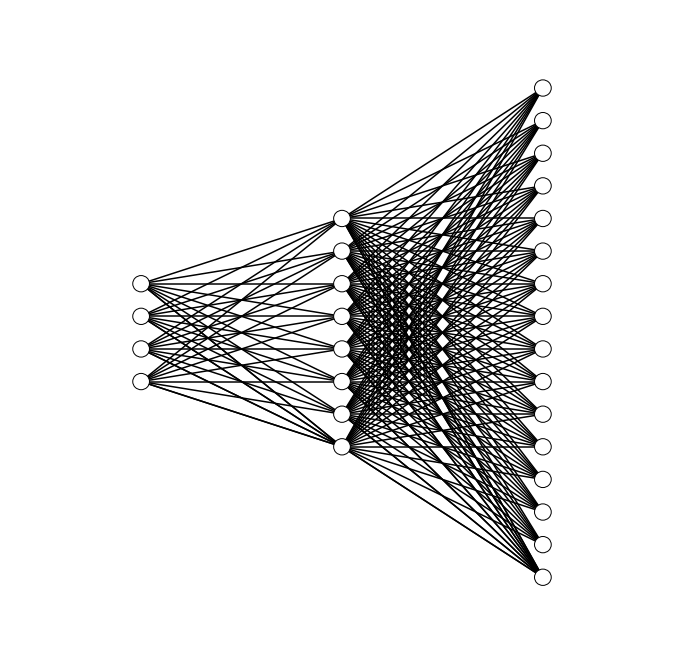

In [160]:
import matplotlib.pyplot as plt
color = ['#ff7f0e', '#1f77b4', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 'lightcoral', 'chocolate', 'black', 'cadetblue', 'mediumaquamarine', 'goldenrod']

def draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    '''
    Draw a neural network cartoon using matplotilb.
    
    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])
    
    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            #if layer_size==layer_sizes[-1]:
                #circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                #color=color[m], ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)
        #for o in range(layer_size_b):
        #    line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
        #                      [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], color='red')
            ax.add_artist(line)

fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
ax.axis('off')
draw_neural_net(ax, .2, .8, .1, .9, [4, 8, 16])

In [51]:
printfig(fig, 'hotsnet.pdf')

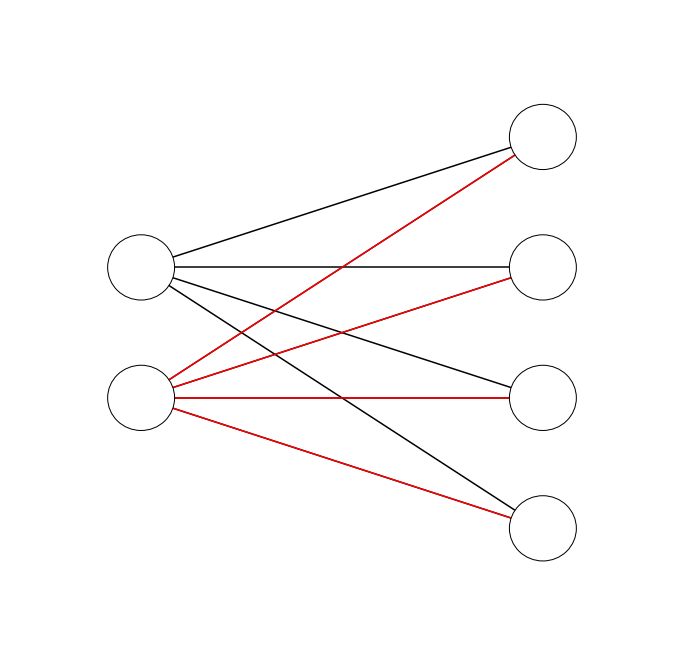

In [131]:
fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
ax.axis('off')
draw_neural_net(ax, .2, .8, .1, .9, [2, 4])

In [132]:
printfig(fig, 'layer.pdf')

# Time Surface

In [194]:
def plote(self, gamma=2.2):
    timesurf = self.getts()
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    legend = ['OFF', 'ON']
    for i in range(len(ax)):
        ax[i].imshow((self.spatpmat[i].T)**gamma, cmap=plt.cm.plasma)
        ax[i].plot(self.x,self.y,'r*')
        ax[i].plot([self.x-self.R, self.x-self.R], [self.y-self.R, self.y+self.R], color='red')
        ax[i].plot([self.x-self.R, self.x+self.R], [self.y-self.R, self.y-self.R], color='red')
        ax[i].plot([self.x-self.R, self.x+self.R], [self.y+self.R, self.y+self.R], color='red')
        ax[i].plot([self.x+self.R, self.x+self.R], [self.y-self.R, self.y+self.R], color='red')
        ax[i].axis('off')
    return fig
        #ax[i].set_title(f'{legend[i]} events with exponential decay')

/home/antoine/homhots/HOTS/HOTS


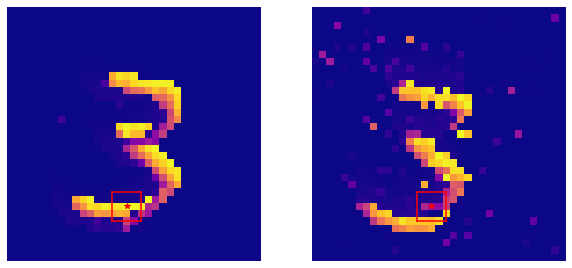

In [195]:
import tonic
from TimeSurface import TimeSurface
%cd '../HOTS/'
learningset = tonic.datasets.NMNIST(save_to='../Data/',download=False,train=False,transform=None)
loader = tonic.datasets.DataLoader(learningset, shuffle=True)

target_event = 2000
SpTetonic = TimeSurface(R=2,tau=50e3,camsize=[34,34])
events, target = next(iter(loader))
iev = 0
while iev<target_event:
    x,y,t,p = events[0][iev][learningset.ordering.find("x")].item(), \
                events[0][iev][learningset.ordering.find("y")].item(), \
                events[0][iev][learningset.ordering.find("t")].item(), \
                events[0][iev][learningset.ordering.find("p")].item(),
    TS, activ = SpTetonic.addevent(x,y,t,p)
    iev+=1
fig = plote(SpTetonic)

In [196]:
printfig(fig, 'time_surface.pdf')

# NN figure

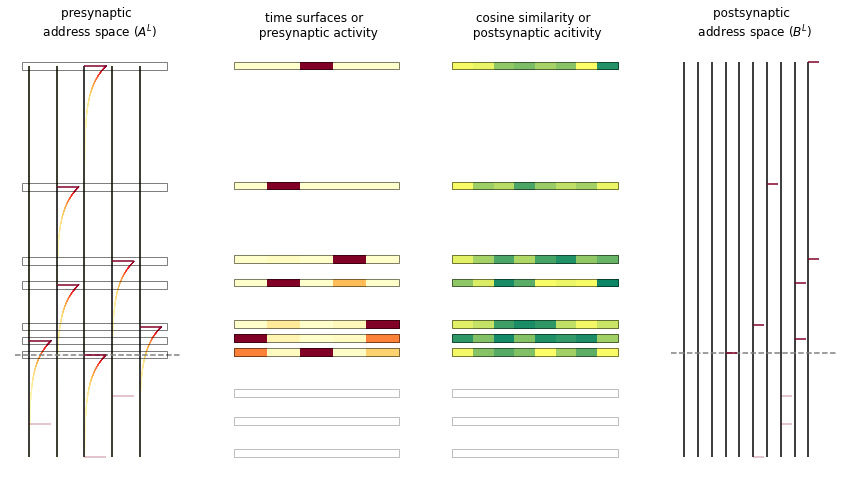

In [442]:
from matplotlib import cm

def norm(x):
    y = (x-np.min(x))/(np.max(x)-np.min(x))
    return y

def box_around(ax, x, alpha, lateral_edges, size):
    ax.hlines(1-x+size, lateral_edges[0], lateral_edges[1], 'k', linewidth=0.5, alpha=alpha)
    ax.hlines(1-x-size, lateral_edges[0], lateral_edges[1], 'k', linewidth=0.5, alpha=alpha)
    ax.vlines(lateral_edges[0],1-x-size, 1-x+size, 'k', linewidth=0.5, alpha=alpha)
    ax.vlines(lateral_edges[1],1-x-size, 1-x+size, 'k', linewidth=0.5, alpha=alpha)
    return ax

def make_ode(t,a,address_number,last_time,t_present):
    a = np.delete(a,np.where(t>1-t_present)[0])
    up_sampling = 100
    tau = 5*up_sampling
    y = np.zeros([address_number, last_time*up_sampling])
    for c in range(address_number):
        t_ev_c = (t[np.where(a==c)[0]]*last_time*up_sampling).astype(int)
        for i in range(len(t_ev_c)):
            x_tp = np.linspace(0,last_time*up_sampling-t_ev_c[i],last_time*up_sampling-t_ev_c[i])
            y_tp = np.exp(-x_tp/tau)
            y[c,t_ev_c[i]:t_ev_c[i]+len(y_tp)] = y_tp
    return y

def plot_event_stream(ax, y, t, len_time, t_present, a, address_number, title, height_spike, ts_box_size, with_decay=True):
    for ad in range(address_number):
        ax.vlines(ad/address_number, 0,1, 'k')
        if with_decay:
            ax.scatter(1/address_number*(ad+np.flip(y[ad])*0.8), np.arange(0,1,1/len(y[ad])), marker='.', s = 3, c=cm.YlOrRd(np.flip(y[ad])), edgecolor='none')
    ax.hlines(t_present, -0.1, 1.1, linestyles='dashed', color='grey')
    for ev in range(nb_events):
        if 1-t[ev]<t_present:
            ax.hlines(1-t[ev], a[ev], a[ev]+height_spike, alpha=0.3, color=cm.YlOrRd(1000))
        else:
            ax.hlines(1-t[ev], a[ev], a[ev]+height_spike, color=cm.YlOrRd(1000))
            if with_decay:
                ax = box_around(ax, t[ev], 1, [-0.05, 1], ts_box_size)
    ax.set_title(title)
    
def plot_ts(ax, y, t, t_present, a, address_number, title, ts_box_size):
    colormap = plt.cm.get_cmap('YlOrRd', 1000);
    for ev in range(nb_events):
        if 1-t[ev]<t_present:
            ax = box_around(ax, t[ev], 0.5, [0, 1], ts_box_size)
        else:
            ax = box_around(ax, t[ev], 1, [0, 1], ts_box_size)
            for i in range(address_number):
                ax.fill_between([i/address_number,(i+1)/address_number], 1-t[ev]-ts_box_size, 1-t[ev]+ts_box_size, color=colormap(y[i,int(y.shape[1]*t[ev])]))
    ax.set_title(title)
    
def plot_simil(ax, t, t_present, kernel_number, title, ts_box_size):
    colormap = plt.cm.get_cmap('summer', 1000);
    for ev in range(nb_events):
        if 1-t[ev]<t_present:
            ax = box_around(ax, t[ev], 0.5, [0, 1], ts_box_size)
        else:
            ax = box_around(ax, t[ev], 1, [0, 1], ts_box_size)
            for i in range(kernel_number):
                ax.fill_between([i/kernel_number,(i+1)/kernel_number], 1-t[ev]-ts_box_size, 1-t[ev]+ts_box_size, color=colormap(np.random.rand(1)))
    ax.set_title(title)
                
def plot_the_figure(address_number, max_time, events_number):
    
    height_spike = 1/address_number*0.8
    ts_box_size = 0.01
    
    fig, ax = plt.subplots(1,4,figsize=(15,8))
    for i in range(len(ax)):
        #for key, spine in ax[i].spines.items():
        #    spine.set_visible(False)
        #ax[i].set_yticks([])
        #ax[i].set_xticks([])
        ax[i].axis('off')
        
    np.random.seed(26)
    t = np.random.randint(low = 1, high = max_time, size = events_number)
    a = np.random.randint(low = 0, high = address_number, size = events_number)
    title = 'presynaptic \n address space ($A^L$)'
    
    len_time = max(t)
    t = np.sort(norm(t))
    t_present = 1-t[6]
    
    y = make_ode(t,a,address_number,len_time,t_present)
    a = a/address_number
    
    ax[0] = plot_event_stream(ax[0], y, t, len_time, t_present, a, address_number, title, height_spike, ts_box_size)
    
    plot_ts(ax[1], y, t, t_present, a, address_number, 'time surfaces or \n presynaptic activity', ts_box_size)
    
    plot_simil(ax[2], t, t_present, 8, 'cosine similarity or \n postsynaptic acitivity', ts_box_size)
    
    address_number *= 2
    height_spike *= .5
    a = np.random.randint(low = 0, high = address_number, size = events_number)
    a = a/address_number
    title = 'postsynaptic \n address space ($B^L$)'
    ax[3] = plot_event_stream(ax[3], y, t, len_time, t_present, a, address_number, title, height_spike, ts_box_size, with_decay=False)
    
    return fig, ax

amax, tmax, nb_events = 5, 100, 10
fig, ax = plot_the_figure(amax, tmax, nb_events)